In [90]:
!pwd

/Users/jinbiao.ji/mygithub/100Earths-GP/MCMC


In [39]:
from matplotlib import rcParams
rcParams.update({'font.size': 14, 'font.family': 'serif'})

### 1. Get data

In [2]:
import numpy as np
from astropy.stats import LombScargle
import matplotlib.pyplot as plt
%matplotlib inline
# Read the data
date, rv, rverr, ha, haerr, nad, naderr, fwhm, fwhmerr, bis, biserr = \
    np.loadtxt("../data/dbf_HARPS.txt", unpack=True, \
    usecols=[1,2,3,4,5,6,7,8,9,10,11], skiprows=21)
dateH, rvH, rverrH, haH, haerrH = \
    np.loadtxt("../data/dbf_HIRES.txt", unpack=True, \
    usecols=[1,2,3,4,5])
first = date[0]
date -= first
dateH -= first
# Put together the HIRES and HARPS measurements of RV and Halpha
alldates = np.concatenate((date, dateH))
allRV = np.concatenate((rv, rvH))
allRVerr = np.concatenate((rverr, rverrH))
allha = np.concatenate((ha, haH))
allhaerr = np.concatenate((haerr, haerrH))
sub = np.argsort(alldates)
alldates = alldates[sub]
allRV = allRV[sub]
allRVerr = allRVerr[sub]
allha = allha[sub]
allhaerr = allhaerr[sub]
# Compute the periodograms
xiR, powR = LombScargle(alldates, allRV, allRVerr).autopower()
xiH, powH = LombScargle(alldates, allha, allhaerr).autopower()

### 3. Set up the Gaussian processes with shared period and decorrelation time; find best-fit parameters:

In [15]:
# To install george: $ conda install -c conda-forge george
# Most of this code is borrowed from a tutorial in the george documentation:
# https://george.readthedocs.io/en/latest/tutorials/hyper/
from george import kernels
from george import GP
from george import modeling
from scipy.optimize import minimize
from scipy.optimize import Bounds

# Initial guesses for the hyperparameters
constant_guess = 50. # Amplitude of squared-exponential decorrelation kernel
metric_guess = 10000. # Decorrelation timescale SQUARED
period_guess = 142.9 # Best-fit rotation period from H alpha
gamma_guess = 2. # Represents (1 / Amplitude) of periodic RV signal

# Create the kernels
kexp2 = constant_guess * kernels.ExpSquaredKernel(metric=metric_guess)
kper = kernels.ExpSine2Kernel(gamma=gamma_guess, log_period=np.log(period_guess))
krot = kexp2 * kper

# Trivial function that returns the white noise amplitudes.
# Note: I'm not 100% sure I'm treating the measurement uncertainties correctly.
def whitenoise(time):
    return np.log(allRVerr**2)

# Initialize the Gaussian process. 
gp = GP(krot, fit_kernel=True, mean=np.mean(allRV), \
        white_noise=modeling.CallableModel(whitenoise, gradient=None))

# Define the objective function that will be used to evaluate the goodness of the fitted
# hyperparameters (negative log-likelihood in this case)
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(allRV, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# Find the gradient of the objective function nll
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(allRV, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(alldates,allRVerr)

# Print the initial ln-likelihood.
print("Initial ln-likelihood:", gp.log_likelihood(allRV))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print("Final ln-likelihood:", gp.log_likelihood(allRV))

# Display results
print(gp.get_parameter_names())
print(results['x'])

Initial ln-likelihood: -210.72952259018444
Final ln-likelihood: -192.68398378116345
('kernel:k1:k1:log_constant', 'kernel:k1:k2:metric:log_M_0_0', 'kernel:k2:gamma', 'kernel:k2:log_period')
[ 1.73775032 11.37660014  1.63261223  4.74932037]


In [16]:
krot # The kernel

ConstantKernel(log_constant=1.7377503244676895, ndim=1, axes=array([0])) * ExpSquaredKernel(metric=Metric(87255.87243851686, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None) * ExpSine2Kernel(gamma=1.6326122255198352, log_period=4.749320366616824, ndim=1, axes=array([0]))

In [17]:
# Human-readable results
print("Constant kernel multiplier:", np.exp(results.x[0]))
print("Sqrt of constant kernel multiplier (physically meaningful):", np.sqrt(np.exp(results.x[0])))
print("Metric:", np.exp(results.x[1]))
print("Decorrelation timescale (sqrt of metric):", np.sqrt(np.exp(results.x[1])), " days")
print("Gamma (multiplier of sin2):", results.x[2])
print("Roughness parameter omega:", np.sqrt(0.5/results.x[2]))
print("Period:", np.exp(results.x[3])," days.")

Constant kernel multiplier: 5.684540655011022
Sqrt of constant kernel multiplier (physically meaningful): 2.384227475517179
Metric: 87255.87243851686
Decorrelation timescale (sqrt of metric): 295.39105003116947  days
Gamma (multiplier of sin2): 1.6326122255198352
Roughness parameter omega: 0.5534055114258486
Period: 115.50575627708531  days.


### 4. use <a href="http://dfm.io/emcee/current/"><tt>emcee</tt></a> to sample the Gaussian process:

#### 4.1 Make the preparation for GP.

In [18]:
import emcee

# Try to make some reasonable priors
def lnprior(pars):
    ln_decorr_time2 = pars[1] # This parameter is ln((decorrelation time)^2)
    ln_period = pars[3]
    # Uniform prior between 5 days and 4 x length of the time series for decorrelation time
    if ((ln_decorr_time2 < np.log(5.**2.)) or (ln_decorr_time2 > np.log(alldates[-1]**2.))):
        return -np.inf
    # Uniform prior for period between 2 days and the 4*length of the time series
    if ((ln_period < np.log(2.)) or (ln_period > np.log(4.*alldates[-1]))):  # 14728 days
        return -np.inf
    # Uniform, barely informative priors for the other parameters
    for i in (0, 2):
        if ((pars[i] < -7.) or (pars[i] > 8.)):
            return -np.inf
    return 0.

# The full log-probability function, including priors
def lnprob(pars):
    gp.set_parameter_vector(pars)
    ll = gp.log_likelihood(allRV, quiet=True)
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll

# Run the Gaussian process again
gp.compute(alldates,allRVerr)
print("Computed the Gaussian process")

# Set up the sampler.
nwalkers, ndim = 50, len(gp)

# Initialize the walkers.
p0 = gp.get_parameter_vector() + 1.0e-4 * np.random.randn(nwalkers, ndim)


Computed the Gaussian process


#### 4.2 Save the progress:

In [43]:
# Set up the backend
filename = 'Kapteyn_GP_MCMC_2.h5'  #Use GP_MCMC.h5 to save the progress
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, backend=backend)

#### 4.3 Sampling with convergence check:

In [44]:
max_n = 20000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, backend=backend)
for sample in sampler.sample(p0, iterations=max_n, progress=True):  # sampler.sample is the same with sampler.run_mcmc
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

100%|██████████| 20000/20000 [18:11<00:00, 18.32it/s]


### 5. Examine MCMC convergence

#### 5.1 Gelman-Rubin Diagnostic:

In [21]:
def gelman_rubin(chain):
    
    def rscore(x, num_samples):
        # Calculate between-chain variance
        B = num_samples * np.var(np.mean(x, axis=1), axis=0, ddof=1)

        # Calculate within-chain variance
        W = np.mean(np.var(x, axis=1, ddof=1), axis=0)

        # Estimate of marginal posterior variance
        Vhat = W * (num_samples - 1) / num_samples + B / num_samples

        return np.sqrt(Vhat / W)
    
    Rhat = {}
    varnumber = chain.shape[2]
    
    for var in range(varnumber):
        x = chain[:,:,var]
        numsaples = x.shape[1]
        Rhat[str(var)] = rscore(x,numsaples)
    
    return Rhat

In [45]:
print("Gelmen-Rubin Diagnostic for each parameter:")
gel = gelman_rubin(sampler.chain[:,burnin:,:])
print('ln(Quasi-per Amplitude):{}'.format(gel['0']))
print('ln(decorr time^2):  \t{}'.format(gel['1']))
print('Gamma: \t\t \t{}'.format(gel['2']))
print('ln(Period): \t\t{}'.format(gel['3']))

Gelmen-Rubin Diagnostic for each parameter:
ln(Quasi-per Amplitude):1.0032040896996155
ln(decorr time^2):  	1.0130726510830683
Gamma: 		 	1.0087972847769417
ln(Period): 		1.0123132570966562


In [46]:
print('Autocorrelation time （iterations):')
print('ln(Quasi-per Amplitude):{}'.format(tau[0]))
print('ln(decorr time^2): \t{}'.format(tau[1]))
print('Gamma: \t\t\t{}'.format(tau[2]))
print('ln(Period): \t\t{}'.format(tau[3]))

Autocorrelation time （iterations):
ln(Quasi-per Amplitude):123.38587387239527
ln(decorr time^2): 	521.1563537698604
Gamma: 			237.7011854179301
ln(Period): 		406.4069872251052


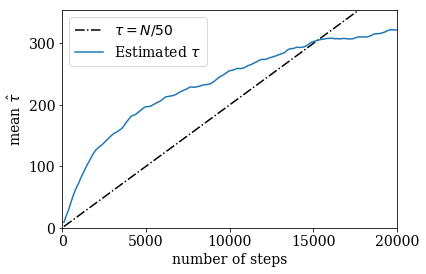

In [47]:
n = 100*np.arange(1, index+1)
y = autocorr[:index]
#plt.plot(n, n / 100.0, "--k", label=r'$\tau = N/100$')
plt.plot(n, n / 50.0, "-.k",label=r'$\tau = N/50$')
plt.plot(n, y, label = r'Estimated $\tau$')
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");
plt.legend()
plt.show()

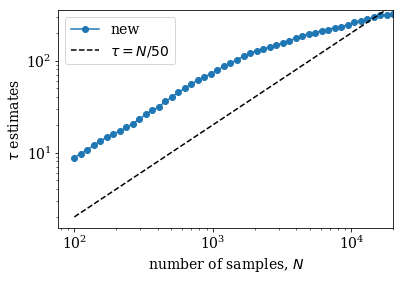

In [48]:
N = np.exp(np.linspace(np.log(100), np.log(sampler.chain.shape[1]), 50)).astype(int)
tau_new = np.empty(len(N))

for i, n in enumerate(N):
    tau_new[i]= np.mean(emcee.autocorr.integrated_time(sampler.get_chain()[:n,:,:], tol=0))

plt.loglog(N,tau_new,"o-", label="new")    
plt.loglog(N, N/50., '--k', label=r'$\tau = N/50$') 
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.xlim(0, N.max())
plt.ylim(0, tau_new.max() + 0.1*(tau_new.max() - tau_new.min()))
plt.legend()
plt.show()

### 6. Examine posteriors:

In [55]:
burnin = int(2*np.max(tau))
print('burn-in: {}'.format(burnin))

burn-in: 1042


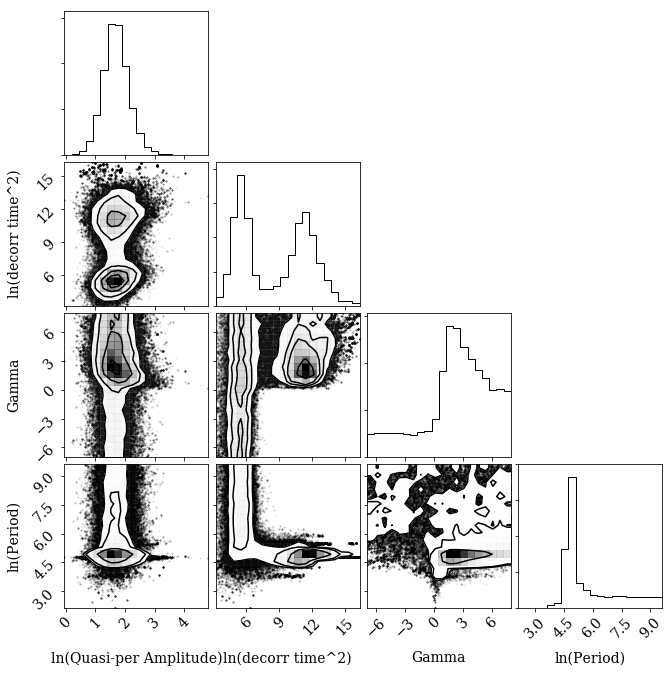

In [53]:
import corner
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
parnames = ["ln(Quasi-per Amplitude)", "ln(decorr time^2)", "Gamma", \
            "ln(Period)"]
cfig = corner.corner(samples, labels=parnames)

Period: 120.58916707668541 days


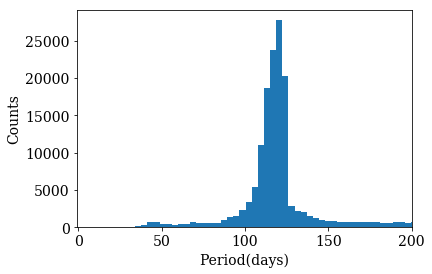

In [69]:
n, bins, _ =plt.hist(np.exp(samples[:,3]), 4000)
#plt.xscale('log')
plt.xlim(-1, 200)
plt.xlabel('Period(days)')
sub_n = np.argmax(n)
print('Period: {} days'.format(0.5*(bins[sub_n]+bins[sub_n+1])))
plt.ylabel('Counts')
plt.show()

Decorr time: 13.326711296591998 days


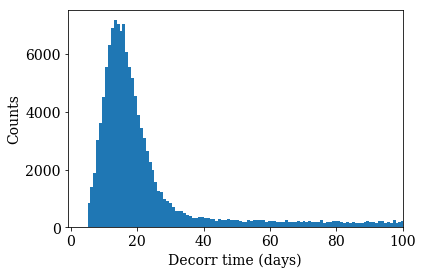

In [72]:
n, bins, _ =plt.hist(np.sqrt(np.exp(samples[:,1])), 4000)
#plt.xscale('log')
plt.xlim(-1, 100)
plt.xlabel('Decorr time (days)')
sub_n = np.argmax(n)
print('Decorr time: {} days'.format(0.5*(bins[sub_n]+bins[sub_n+1])))
plt.ylabel('Counts')
plt.show()

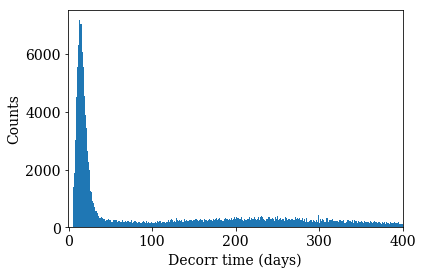

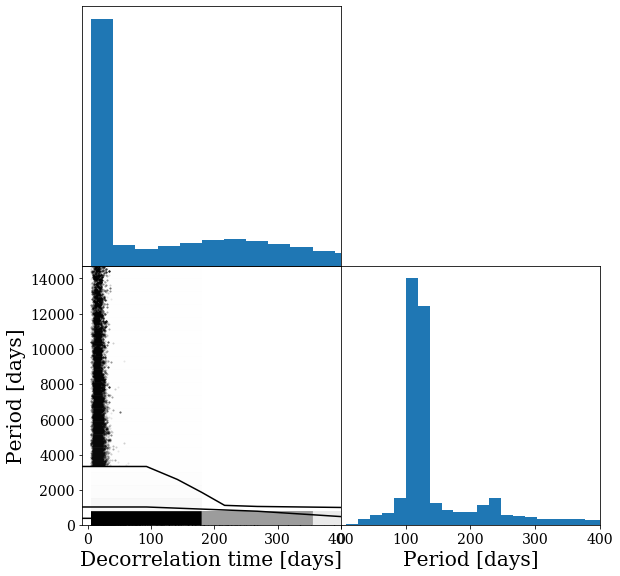

In [58]:
ln_decorr_times2 = samples[:,1]
decorr_times = np.sqrt(np.exp(ln_decorr_times2))
ln_periods = samples[:,3]
periods = np.exp(ln_periods)
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.1, 0.1, 0.45, 0.45])
ax2 = fig.add_axes([0.55, 0.1, 0.45, 0.45])
ax3 = fig.add_axes([0.1, 0.55, 0.45, 0.45], sharex=ax1)
corner.hist2d(decorr_times, periods, ax=ax1)
n1, bins1, patches = ax3.hist(decorr_times, bins=100)
n2, bins2, patches = ax2.hist(periods, bins=800)
ax1.set_xlabel("Decorrelation time [days]", fontsize="x-large")
ax2.set_xlim([0,400])
ax1.set_ylabel("Period [days]", fontsize="x-large")
ax2.set_xlabel("Period [days]", fontsize="x-large")
ax1.set_xlim([-10,400])
#ax1.set_ylim([0,2000])
ax2.yaxis.set_visible(False)
ax3.yaxis.set_visible(False)
ax3.xaxis.set_visible(False)
# ax2.set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750])

Text(0.5, 0, 'Step number')

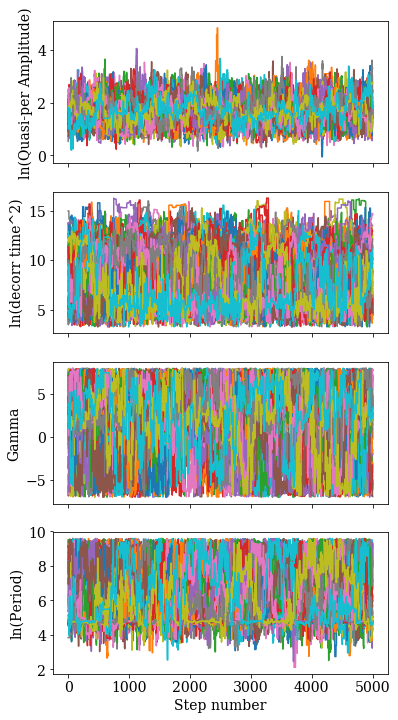

In [73]:
fig, axarr = plt.subplots(4, sharex=True, figsize=(6,12))
nsteps = sampler.chain.shape[1]
step = range(nsteps)
for i in range(len(axarr)):
    for w in range(nwalkers):
        axarr[i].plot(step[0:5000], sampler.chain[w,15000:,i])
    axarr[i].set_ylabel(parnames[i])
axarr[3].set_xlabel('Step number');

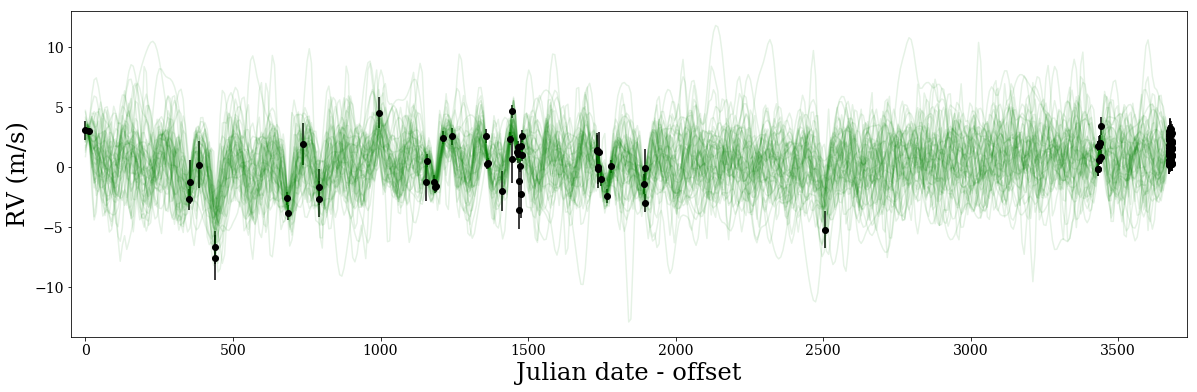

In [56]:
# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, 15000:, :].reshape((-1, ndim))
plt.figure(figsize=(20,6))
# Plot 50 possible RV curves drawn from the flat chain, along with the data
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)
for i in range(50):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    gp.set_parameter_vector(samples[n])
    # Plot a single sample.
    plt.plot(tt, gp.sample_conditional(allRV, tt), 'g',  alpha=0.1)
# Plot the real data
plt.errorbar(alldates, allRV, yerr=allRVerr, c='k', fmt='o')
plt.xlim(alldates[0]-50, alldates[-1]+50)
plt.xlabel("Julian date - offset", fontsize='xx-large')
plt.ylabel("RV (m/s)", fontsize='xx-large');
plt.show()

### Residues:

The maximum power is 35.5754 days


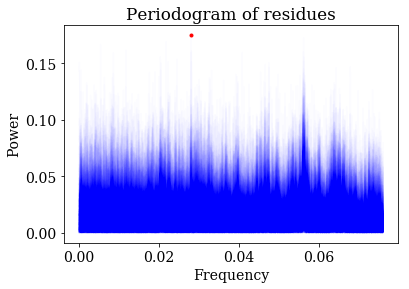

In [62]:
from scipy.signal import find_peaks
from astropy.stats import LombScargle

# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, 15000:, :].reshape((-1, ndim))
#plt.figure(figsize=(15,6))
# Plot 50 possible RV curves drawn from the flat chain, along with the data
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)
pds = np.zeros(500)
pspecs = np.zeros(500)
specs =np.array([])
periods = np.array([])

for r in range(500):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    gp.set_parameter_vector(samples[n])
    
    #get residuals
    resid = allRV - gp.sample_conditional(allRV,alldates) 
                
    #periodogram
    xi, pspec = LombScargle(alldates, resid, allRVerr).autopower()
    sub = np.argmax(pspec)
    pds[r] = 1.0/xi[sub]
    pspecs[r] = pspec[sub]
    plt.plot(xi, pspec, 'b-', alpha=0.01)
    
    #find the first 10 highest peaks.
    peaks, _ = find_peaks(pspec, height=0.06)
    ind = np.argsort(pspec[peaks])
    ind = peaks[ind[-10:]]
    
    periods = np.append(periods,1.0/xi[ind])
    specs = np.append(specs, pspec[ind])
    
plt.title('Periodogram of residues')
plt.xlabel('Frequency')
plt.ylabel('Power')
#plt.xscale('log')
plt.plot(1.0/pds[np.argmax(pspecs)], np.max(pspecs),'r.')
print('The maximum power is {:.4f} days'.format(pds[np.argmax(pspecs)]))

#### The distribution of periods in residues:

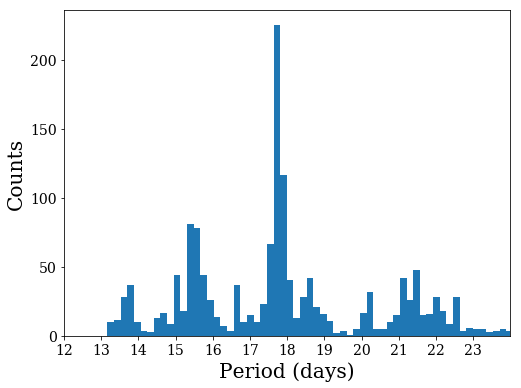

In [89]:
plt.figure(figsize=(8,6))
N, bins, _=plt.hist(periods[np.where(periods<40)],bins=150)
plt.xlim(12,24)
plt.xlabel('Period (days)',fontsize='x-large')
plt.ylabel('Counts',fontsize='x-large');
#plt.title('Distribution of the first 5 dominant periods of each residue',fontsize='x-large')
plt.xticks(np.arange(12,24));

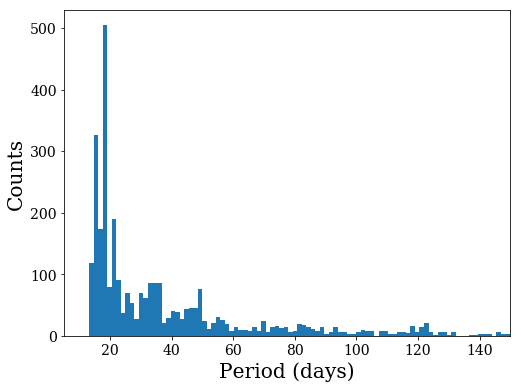

The maximum power is 14.6520 days


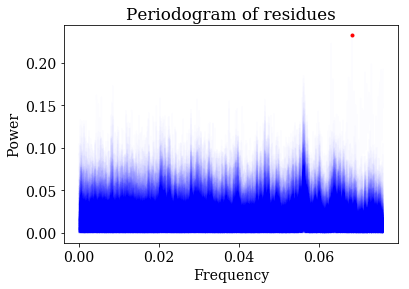

In [60]:
# Make a flat chain of samples with the initial burn-in discarded
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
#plt.figure(figsize=(15,6))
# Plot 50 possible RV curves drawn from the flat chain, along with the data
tt = np.linspace(alldates[0], alldates[-1], 501, endpoint=True)
pds = np.zeros(500)
pspecs = np.zeros(500)
specs =np.array([])
periods = np.array([])

for r in range(500):
    # Choose a sample
    n = np.random.randint(0, samples.shape[0])
    gp.set_parameter_vector(samples[n])
    
    #get residuals
    resid = allRV - gp.sample_conditional(allRV,alldates) 
                
    #periodogram
    xi, pspec = LombScargle(alldates, resid, allRVerr).autopower()
    sub = np.argmax(pspec)
    pds[r] = 1.0/xi[sub]
    pspecs[r] = pspec[sub]
    plt.plot(xi, pspec, 'b-', alpha=0.01)
    
    #find the first 10 highest peaks.
    peaks, _ = find_peaks(pspec, height=0.06)
    ind = np.argsort(pspec[peaks])
    ind = peaks[ind[-10:]]
    
    periods = np.append(periods,1.0/xi[ind])
    specs = np.append(specs, pspec[ind])
    
plt.title('Periodogram of residues')
plt.xlabel('Frequency')
plt.ylabel('Power')
#plt.xscale('log')
plt.plot(1.0/pds[np.argmax(pspecs)], np.max(pspecs),'r.')
print('The maximum power is {:.4f} days'.format(pds[np.argmax(pspecs)]))

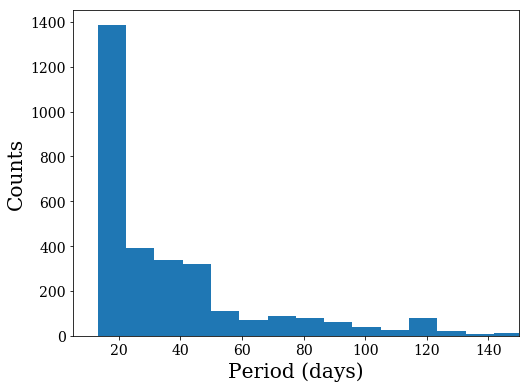

In [61]:
plt.figure(figsize=(8,6))
N, bins, _=plt.hist(periods,bins=800)
plt.xlim(5,150)
plt.xlabel('Period (days)',fontsize='x-large')
plt.ylabel('Counts',fontsize='x-large');
#plt.title('Distribution of the first 5 dominant periods of each residue',fontsize='x-large')
